In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('Region_NW.xlsx')
demand = data[['UTC time','D']].dropna()

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(demand.set_index('UTC time'))
plt.show()

In [ ]:
demand_pct = demand.set_index('UTC time').pct_change(1).dropna()
# demand_pct_2 = demand_pct[['D']].pct_change(1).dropna()
plt.figure(figsize=(15,8))
plt.title('Northwest Demand Time Series 07/2015 to 01/2023',size=18)
plt.xlabel('Time (by hour)')
plt.ylabel('Hourly Percentage change')
plt.plot(demand_pct['D'])
plt.show()

The above plot clearly shows that there is an anomoly at the very beginning of our data. So we draw another plot without the extreme instance.

In [ ]:
plt.figure(figsize=(15,8))
plt.title('Northwest Demand Time Series 07/2015 to 01/2023',size=18)
plt.xlabel('Time (by hour)')
plt.ylabel('Hourly Percentage change')
plt.plot(demand_pct.iloc[1:])
plt.show()

In [ ]:
monthly_pct = demand_pct.groupby(pd.Grouper(freq='M')).mean().reset_index()
heatmap_df = {i:{j:0 for j in range(1,13)} for i in range(2015,2024)}
for i in range(len(monthly_pct)):
    tmp = monthly_pct.iloc[i]
    heatmap_df[tmp['UTC time'].year][tmp['UTC time'].month] = tmp.D

In [ ]:
plt.figure(figsize=(12,10))
sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(pd.DataFrame(heatmap_df), annot=True, cmap='Blues')
plt.title('Heatmap for Monthly Pct Change',size=18)
plt.xlabel('Year',size=12)
plt.ylabel('Month',size=12)
plt.show()

---

## New Data

In [6]:
from sklearn.ensemble import IsolationForest
import os

In [7]:
new_data = pd.read_csv('data.csv')
new_data.set_index('UTC time',inplace=True)
new_data.head()

,D,delta_D,delta_2_D,D_BPAT,D_NEVP,D_PACE,D_PACW,D_PSCO,D_WACM,D_PSEI,delta_D_0
UTC time,,,,,,,,,,,
2015-07-01 09:00:00,-1.015285,-1.411605,-0.044119,-1.045912,1.020153,0.008060,-0.037874,-0.827647,-0.619262,-0.060177,0
2015-07-01 10:00:00,-1.196581,-0.884714,-0.016562,-1.198565,0.817298,0.007366,-0.042391,-0.913098,-0.729841,-0.204687,0
2015-07-01 11:00:00,-1.286189,-0.460468,-0.021280,-1.273375,0.649419,0.006837,-0.044805,-0.882212,-0.784497,-0.232477,0
2015-07-01 12:00:00,-1.257591,0.125195,-0.056607,-1.229905,0.576846,0.007538,-0.046284,-0.747343,-0.767054,-0.185789,0
2015-07-01 13:00:00,-1.087907,0.828430,0.206917,-1.070175,0.517389,0.008850,-0.042196,-0.432305,-0.663557,-0.009042,0


In [8]:
inf_indices = np.where(new_data.isin([np.inf, -np.inf]))
nan_indices = np.where(new_data.isna())

print("Indices with infinite values:", inf_indices)
print("Indices with NaN values:", nan_indices)

Indices with infinite values: (array([], dtype=int64), array([], dtype=int64))
Indices with NaN values: (array([], dtype=int64), array([], dtype=int64))


In [19]:
new_data = new_data.replace([np.inf, -np.inf], np.nan)  # replace inf with NaN
new_data = new_data.fillna(method='ffill', axis=0)  # fill NaN with previous value
x1 = 'D'
x2 = 'delta_D'
X = new_data[[x1, x2]]

In [26]:
isof = IsolationForest(n_estimators=300, contamination=0.0008, random_state=47)
isof.fit(X)
# Predict the anomalies in the data
anomaly_scores = isof.decision_function(X)
anomaly_labels = isof.predict(X)

# replace known anomaly indexes to -1
zero_delta = np.where(new_data['delta_D'] == 0)[0]
# anomaly_labels[zero_delta] = -2

# Output the anomaly labels
new_data['anomaly_label'] = anomaly_labels
anomalies = new_data[new_data['anomaly_label'] == -1]
# delta_zeros = new_data[new_data['anomaly_label'] == -2]

F:\anaconda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


[1 1 1 ... 1 1 1]


In [ ]:
print(anomaly_labels)

F:\anaconda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


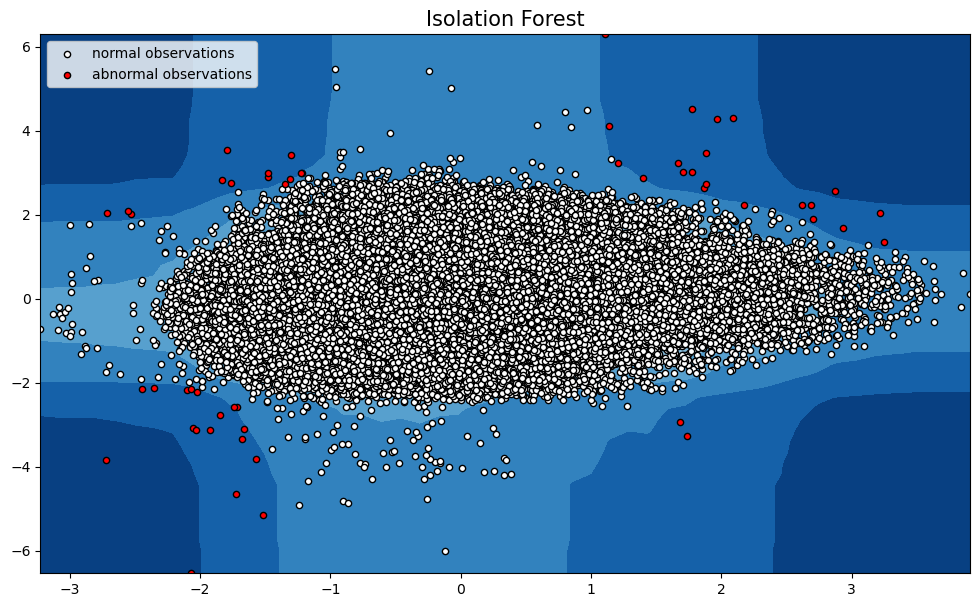

In [30]:
X_inliers = new_data.loc[new_data['anomaly_label']==1][[x1,x2]]
X_outliers = new_data.loc[new_data['anomaly_label']==-1][[x1,x2]]
xx, yy = np.meshgrid(np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 50), np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), 50))
Z = isof.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(12, 7))
plt.title("Isolation Forest", fontsize = 15, loc='center')
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

inl = plt.scatter(X_inliers.iloc[:, 0], X_inliers.iloc[:, 1], c='white', s=20, edgecolor='k')
outl = plt.scatter(X_outliers.iloc[:, 0], X_outliers.iloc[:, 1], c='red',s=20, edgecolor='k')

plt.axis('tight')
plt.xlim((X.iloc[:, 0].min(), X.iloc[:, 0].max()))
plt.ylim((X.iloc[:, 1].min(), X.iloc[:, 1].max()))
plt.legend([inl, outl],["normal observations", "abnormal observations"],loc="upper left")
plt.show()

In [ ]:
# plt.figure(figsize=(15,7))
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(pd.to_datetime(new_data.index.to_list()), new_data['D'], alpha=0.6,label='Demand')
ax.scatter(pd.to_datetime(anomalies.index.to_list()), anomalies['D'], color='red', label='Anomalies labeled by iForest')
# ax.scatter(pd.to_datetime(delta_zeros.index.to_list()), delta_zeros['D'], color='green', label='Zero Delta')

plt.legend()
plt.show()

---

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


In [125]:
# Split data into training and test sets
train_size = int(len(new_data) * 0.7)
train_data, test_data = new_data.iloc[:train_size].copy(), new_data.iloc[train_size:].copy()

### label anomalies in train data 

In [126]:
# Define the number of windows and the window size
n_windows = 10
window_size = len(train_data) // n_windows

# Initialize a list to store the anomaly labels for each window
anomaly_labels = []

end_indexes = []

for i in range(n_windows):
    start_index = i * window_size
    end_index = (i + 1) * window_size if i < n_windows - 1 else len(train_data)
    end_indexes.append(end_index)
    # Extract the current window from the train_data DataFrame
    window = train_data.iloc[start_index:end_index].copy()
    
    # Label anomalies within the current window using the np.where function
    window['anomaly_label'] = np.where((window['D'] > window['D'].quantile(0.9995)) | (window['D'] < window['D'].quantile(0.0005)), -1, 1)
    
    # Append the anomaly labels for the current window to the list
    anomaly_labels.append(window['anomaly_label'])

anomaly_labels = pd.concat(anomaly_labels)
zero_delta = np.where(train_data['delta_D'] == 0)[0]
anomaly_labels[zero_delta] = -1

train_data['anomaly_label'] = anomaly_labels

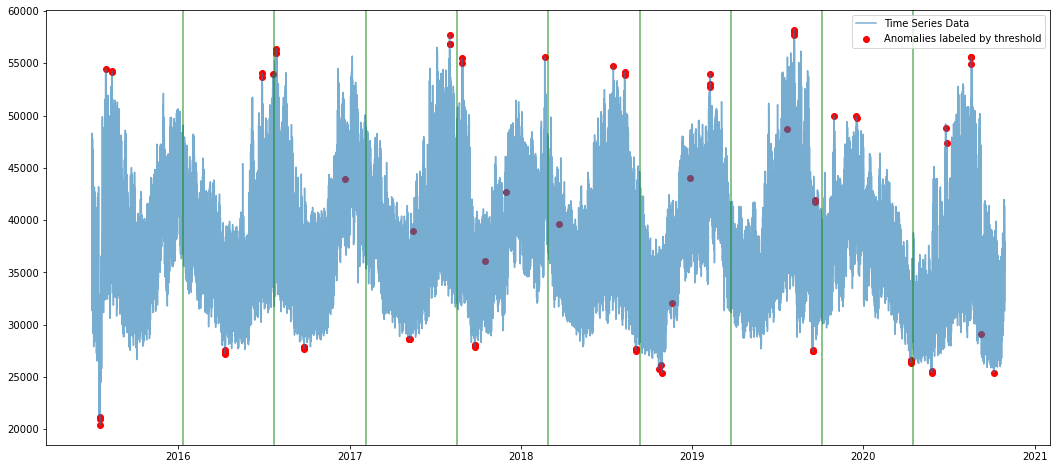

In [127]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(pd.to_datetime(train_data.index), train_data['D'], alpha=0.6, label='Time Series Data')

ax.scatter(pd.to_datetime(train_data[train_data['anomaly_label']==-1].index), train_data[train_data['anomaly_label']==-1]['D'], color='red', label='Anomalies labeled by threshold')

# draw windows
for index in train_data.index[end_indexes[:-1]]:
    ax.axvline(pd.to_datetime(index), color='green', alpha=0.6)

plt.legend()
plt.show()

### Label anomalies in test data

In [128]:
# Define the number of windows and the window size
n_windows = 10
window_size = len(test_data) // n_windows

# Initialize a list to store the anomaly labels for each window
anomaly_labels = []

end_indexes = []

for i in range(n_windows):
    start_index = i * window_size
    end_index = (i + 1) * window_size if i < n_windows - 1 else len(test_data)
    end_indexes.append(end_index)
    # Extract the current window from the train_data DataFrame
    window = test_data.iloc[start_index:end_index].copy()
    
    # Label anomalies within the current window using the np.where function
    window['anomaly_label'] = np.where((window['D'] > window['D'].quantile(0.9995)) | (window['D'] < window['D'].quantile(0.0005)), -1, 1)
    
    # Append the anomaly labels for the current window to the list
    anomaly_labels.append(window['anomaly_label'])

anomaly_labels = pd.concat(anomaly_labels)
zero_delta = np.where(test_data['delta_D'] == 0)[0]
anomaly_labels[zero_delta] = -1

test_data['anomaly_label'] = anomaly_labels

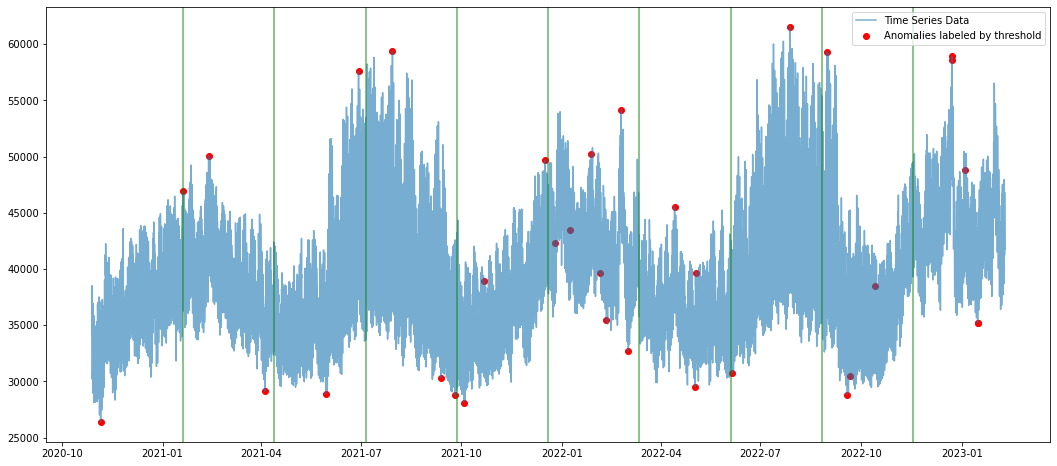

In [129]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(pd.to_datetime(test_data.index), test_data['D'], alpha=0.6, label='Time Series Data')

ax.scatter(pd.to_datetime(test_data[test_data['anomaly_label']==-1].index), test_data[test_data['anomaly_label']==-1]['D'], color='red', label='Anomalies labeled by threshold')

# draw windows
for index in test_data.index[end_indexes[:-1]]:
    ax.axvline(pd.to_datetime(index), color='green', alpha=0.6)

plt.legend()
plt.show()

### RF classifier

In [144]:
# # Define the hyperparameter space to search
# param_grid = {'n_estimators': [100, 150, 200],
#                        'max_depth': [5, 10, 20],
#                        'min_samples_split': [2, 5, 10],
#                        'max_features': ['auto', 'sqrt']}

# # Create the random search object
# rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
#                                param_distributions=param_grid,
#                                n_iter=100,
#                                cv=5,
#                                random_state=42,
#                                n_jobs=-1)

# # Fit the random search object to the training data
# rf_random.fit(train_data.iloc[:, :-1], train_data['anomaly_label'])

# # Get the best hyperparameters and fit the final model
# best_params = rf_random.best_params_
# rf = RandomForestClassifier(random_state=42, **best_params)
rf = RandomForestClassifier(n_estimators=150, max_depth=5, min_samples_split=50, random_state=42)
rf.fit(train_data.iloc[:, :-1], train_data['anomaly_label'])
y_pred = rf.predict(test_data.iloc[:,:-1])
y_true = test_data['anomaly_label']


RandomForestClassifier(max_depth=5, min_samples_split=50, n_estimators=150,
                       random_state=42)

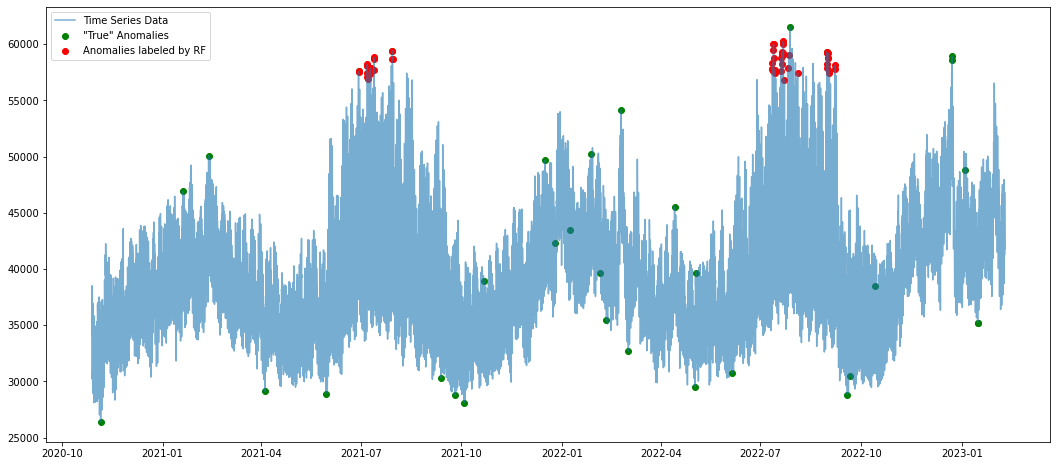

In [146]:
plot_test_data = test_data.copy()
plot_test_data['y_pred'] = y_pred

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(pd.to_datetime(plot_test_data.index), plot_test_data['D'], alpha=0.6, label='Time Series Data')
ax.scatter(pd.to_datetime(plot_test_data[plot_test_data['anomaly_label']==-1].index), plot_test_data[plot_test_data['anomaly_label']==-1]['D'], color='green', label='"True" Anomalies')
ax.scatter(pd.to_datetime(plot_test_data[plot_test_data['y_pred']==-1].index), plot_test_data[plot_test_data['y_pred']==-1]['D'], color='red', label='Anomalies labeled by RF')

plt.legend()
plt.show()

In [156]:
new_data

,D,delta_D,delta_2_D,D_BPAT,D_NEVP,D_PACE,D_PACW,D_PSCO,D_WACM,D_PSEI
UTC time,,,,,,,,,,
2015-07-01 09:00:00,33142.0,-0.050753,-1.029286,5329.0,5475.0,5933.0,1597.0,4427.0,2406.886825,2865.0
2015-07-01 10:00:00,32096.0,-0.031561,-0.378145,5178.0,5243.0,5840.0,1481.0,4344.0,2346.138275,2735.0
2015-07-01 11:00:00,31579.0,-0.016108,-0.489628,5104.0,5051.0,5769.0,1419.0,4374.0,2316.112462,2710.0
2015-07-01 12:00:00,31744.0,0.005225,-1.324374,5147.0,4968.0,5863.0,1381.0,4505.0,2325.695169,2752.0
2015-07-01 13:00:00,32723.0,0.030840,4.902493,5305.0,4900.0,6039.0,1486.0,4811.0,2382.552559,2911.0
...,...,...,...,...,...,...,...,...,...,...
2023-02-09 03:00:00,46834.0,0.013240,-0.762934,7736.0,4147.0,6430.0,2826.0,5599.0,4223.000000,3751.0
2023-02-09 04:00:00,46233.0,-0.012833,-1.969194,7726.0,4137.0,6320.0,2813.0,5503.0,4075.000000,3690.0
2023-02-09 05:00:00,45274.0,-0.020743,0.616417,7591.0,4085.0,6198.0,2745.0,5276.0,4122.000000,3570.0


In [162]:
from sklearn.ensemble import RandomForestRegressor

# Split data into training and test sets
train_size = int(len(new_data) * 0.7)
train_data, test_data = new_data.iloc[:train_size].copy(), new_data.iloc[train_size:].copy()

window_size = 10
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data.iloc[i-window_size:i, :])
    y_train.append(train_data.iloc[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Create sliding windows for test data
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data.iloc[i-window_size:i, :])
    y_test.append(test_data.iloc[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [167]:
X_train.shape

(46693, 10, 10)